# Importing python libraries

In [291]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import dateutil.parser as dparser

# Reading dataset

###### Load loan.csv in a dataframe

In [292]:
# Specify columns which need to be parsed as dates
parse_dates = ["last_pymnt_d", "next_pymnt_d"]

In [293]:
loan_df = pd.read_csv("loan.csv", parse_dates = parse_dates)

# Data Overview

In [294]:
print("Dimention of the original dataset: ", loan_df.shape)
print("\nSome records from top and bottom of the dataset: ")
pd.concat([loan_df.head(3), loan_df.tail(3)])

Dimention of the original dataset:  (39717, 111)

Some records from top and bottom of the dataset: 


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
39714,90395,90390,5000,5000,1325.0,36 months,8.07%,156.84,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39715,90376,89243,5000,5000,650.0,36 months,7.43%,155.38,A,A2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39716,87023,86999,7500,7500,800.0,36 months,13.75%,255.43,E,E2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


So our dataset is huge with **111 features** and **39717 records**.

In [295]:
print("Datatypes used: ")
pd.value_counts(loan_df.dtypes)

Datatypes used: 


float64    74
object     24
int64      13
dtype: int64

Above data shows the count of columns grouped by datatypes

In [296]:
print("Detailed information about individual column's datatype and count of non-null values present in them:\n")
loan_df.info(verbose = True, show_counts = True)

Detailed information about individual column's datatype and count of non-null values present in them:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
 #    Column                          Non-Null Count  Dtype  
---   ------                          --------------  -----  
 0    id                              39717 non-null  int64  
 1    member_id                       39717 non-null  int64  
 2    loan_amnt                       39717 non-null  int64  
 3    funded_amnt                     39717 non-null  int64  
 4    funded_amnt_inv                 39717 non-null  float64
 5    term                            39717 non-null  object 
 6    int_rate                        39717 non-null  object 
 7    installment                     39717 non-null  float64
 8    grade                           39717 non-null  object 
 9    sub_grade                       39717 non-null  object 
 10   emp_title                       37258

We have got some basic information about our dataset -
- Dimention
- Column names
- Datatypes
- Non-null counts for every column

We have seen that this dataset has too many features, now we will filter out some of the features which are not important so that we can focus on features which can derive most meaningful results.

# Data cleaning

In [297]:
# Verifying if id and member_id columns are just identifiers
print("id column an identifier: " + str(loan_df["id"].is_unique))
print("member_id column an identifier: " + str(loan_df["member_id"].is_unique))

id column an identifier: True
member_id column an identifier: True


We can drop columns id and member_id as each values for them are unique so they are just identifiers

In [298]:
columns_to_drop = ["id", "member_id"]


<b>We can also drop below columns based on the respective observations -</b>
<ul>
    <li><b>url</b>: it is essenatially derived from id and hence is unique for each records</li>
    <li><b>desc</b>: we can't extract much information from this loan description column</li>
    <li><b>emp_title</b>: seems to be just some company names from the customers records</li>
    <li><b>zip_code</b>: it's a masked data</li>
    <li><b>title</b>: loan title provided by borrower are very random and can't add any value to EDA</li>
    <li>customer behaviour variables can be ignored as they are not available during the loan application
        <ul>
            <li><b>delinq_2yrs</b></li>
            <li><b>earliest_cr_line</b></li>
            <li><b>inq_last_6mths</b></li>
            <li><b>open_acc</b></li>
            <li><b>pub_rec</b></li>
            <li><b>revol_bal</b></li>
            <li><b>revol_util</b></li>
            <li><b>total_acc</b></li>
            <li><b>out_prncp</b></li>
            <li><b>out_prncp_inv</b></li>
            <li><b>total_pymnt</b></li>
            <li><b>total_pymnt_inv</b></li>
            <li><b>total_rec_prncp</b></li>
            <li><b>total_rec_int</b></li>
            <li><b>total_rec_late_fee</b></li>
            <li><b>recoveries</b></li>
            <li><b>collection_recovery_fee</b></li>
            <li><b>last_pymnt_d</b></li>
            <li><b>last_pymnt_amnt</b></li>
            <li><b>last_credit_pull_d</b></li>
            <li><b>application_type</b></li>
        </ul>
    </li>
</ul>
    

In [299]:
columns_to_drop.extend(["url", "desc", "emp_title", "zip_code", "title", "delinq_2yrs", "earliest_cr_line", "inq_last_6mths", "open_acc", "pub_rec", "revol_bal", "revol_util", "total_acc", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt", "last_credit_pull_d", "application_type"])

In [300]:
print("Dropping off", len(columns_to_drop), "columns from dataframe...")
loan_df.drop(columns = columns_to_drop, inplace = True)
print("Dimention of the new dataset: ", loan_df.shape)

Dropping off 28 columns from dataframe...
Dimention of the new dataset:  (39717, 83)


### Inspecting columns with all null values

In [301]:
columns_with_no_data = loan_df.columns[loan_df.isnull().all()].to_list()
print("These are the columns having all null values:")
columns_with_no_data

These are the columns having all null values:


['mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'tot_hi_cred_lim',
 'total_bal

In [302]:
print("Removing", len(columns_with_no_data), "columns having 0 non-null values...")
loan_df.drop(columns = columns_with_no_data, inplace = True)
print("Dimention of the new dataset: ", loan_df.shape)

Removing 54 columns having 0 non-null values...
Dimention of the new dataset:  (39717, 29)


### Analysing missing values

In [303]:
print("Missing values percentage in each column:")
round(loan_df.isnull().sum() / loan_df.shape[0], 3) * 100

Missing values percentage in each column:


loan_amnt                      0.0
funded_amnt                    0.0
funded_amnt_inv                0.0
term                           0.0
int_rate                       0.0
installment                    0.0
grade                          0.0
sub_grade                      0.0
emp_length                     2.7
home_ownership                 0.0
annual_inc                     0.0
verification_status            0.0
issue_d                        0.0
loan_status                    0.0
pymnt_plan                     0.0
purpose                        0.0
addr_state                     0.0
dti                            0.0
mths_since_last_delinq        64.7
mths_since_last_record        93.0
initial_list_status            0.0
next_pymnt_d                  97.1
collections_12_mths_ex_med     0.1
policy_code                    0.0
acc_now_delinq                 0.0
chargeoff_within_12_mths       0.1
delinq_amnt                    0.0
pub_rec_bankruptcies           1.8
tax_liens           

Missing values percentage is varying from 0 to 97% across the columns.
Let's drop any column having more than 30% missing values

In [304]:
columns_with_highers_null_values = loan_df.columns[100*(loan_df.isnull().sum() / loan_df.shape[0]) > 30]
print("No. of such columns are:", len(columns_with_highers_null_values))
print(columns_with_highers_null_values.to_list())

No. of such columns are: 3
['mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d']


In [305]:
# Droping columns with more that 30% missing values
loan_df.drop(columns = columns_with_highers_null_values, inplace = True)
print("Dimention of the new dataset: ", loan_df.shape)

Dimention of the new dataset:  (39717, 26)


#### Analysing columns tax_liens and delinq_amnt because all values are either null or 0

In [306]:
print("Values in tax_liens - ")
loan_df["tax_liens"].value_counts()

Values in tax_liens - 


0.0    39678
Name: tax_liens, dtype: int64

In [307]:
print("Values in delinq_amnt - ")
loan_df["delinq_amnt"].value_counts()

Values in delinq_amnt - 


0    39717
Name: delinq_amnt, dtype: int64

In [308]:
# Dropping tax_liens and delinq_amnt columns as they contain only zeros
loan_df.drop(columns = ["tax_liens", "delinq_amnt"], inplace = True)
print("Dimention of the new dataset: ", loan_df.shape)

Dimention of the new dataset:  (39717, 24)


#### Analysing loan_status column

In [309]:
loan_df["loan_status"].value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

We can dropoff "Current" loan_status from the dataset because we can not do a prescriptive analysis on the ongoing loans

In [310]:
loan_df = loan_df[~(loan_df["loan_status"] == "Current")]
print("Dimention of the new dataset: ", loan_df.shape)

Dimention of the new dataset:  (38577, 24)


#### Analysing initial_list_status column

In [311]:
loan_df["initial_list_status"].value_counts()

f    38577
Name: initial_list_status, dtype: int64

initial_list_status has only one value "f" for all records. We can drop off this column from EDA perspective.

In [312]:
loan_df.drop("initial_list_status", axis = 1, inplace = True)
print("Dimention of the new dataset: ", loan_df.shape)

Dimention of the new dataset:  (38577, 23)


#### Analysing policy_code column

In [313]:
loan_df["policy_code"].value_counts()

1    38577
Name: policy_code, dtype: int64

In [314]:
# Drop policy_code column as it has only one value "1" across the records
loan_df.drop("policy_code", axis = 1, inplace = True)
print("Dimention of the new dataset: ", loan_df.shape)

Dimention of the new dataset:  (38577, 22)


#### Analysing pymnt_plan column

In [315]:
loan_df["pymnt_plan"].value_counts()

n    38577
Name: pymnt_plan, dtype: int64

In [316]:
# Drop pymnt_plan column as it has only one value "n" across the records
loan_df.drop("pymnt_plan", axis = 1, inplace = True)
print("Dimention of the new dataset: ", loan_df.shape)

Dimention of the new dataset:  (38577, 21)


#### Analysing collections_12_mths_ex_med column

In [317]:
loan_df["collections_12_mths_ex_med"].value_counts()

0.0    38521
Name: collections_12_mths_ex_med, dtype: int64

In [318]:
# Drop collections_12_mths_ex_med column as it is either 0 or null across the records
loan_df.drop("collections_12_mths_ex_med", axis = 1, inplace = True)
print("Dimention of the new dataset: ", loan_df.shape)

Dimention of the new dataset:  (38577, 20)


#### Analysing acc_now_delinq column

In [319]:
loan_df["acc_now_delinq"].value_counts()

0    38577
Name: acc_now_delinq, dtype: int64

In [320]:
# Drop acc_now_delinq column as it has only one value "0" across the records
loan_df.drop("acc_now_delinq", axis = 1, inplace = True)
print("Dimention of the new dataset: ", loan_df.shape)

Dimention of the new dataset:  (38577, 19)


#### Analysing chargeoff_within_12_mths column

In [321]:
loan_df["chargeoff_within_12_mths"].value_counts()

0.0    38521
Name: chargeoff_within_12_mths, dtype: int64

In [322]:
# Drop chargeoff_within_12_mths column as it is either 0 or null across the records
loan_df.drop("chargeoff_within_12_mths", axis = 1, inplace = True)
print("Dimention of the new dataset: ", loan_df.shape)

Dimention of the new dataset:  (38577, 18)


#### Duplicate data inspection

In [323]:
loan_df.duplicated().any()

False

In [324]:
loan_df.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             38577 non-null  int64  
 1   funded_amnt           38577 non-null  int64  
 2   funded_amnt_inv       38577 non-null  float64
 3   term                  38577 non-null  object 
 4   int_rate              38577 non-null  object 
 5   installment           38577 non-null  float64
 6   grade                 38577 non-null  object 
 7   sub_grade             38577 non-null  object 
 8   emp_length            37544 non-null  object 
 9   home_ownership        38577 non-null  object 
 10  annual_inc            38577 non-null  float64
 11  verification_status   38577 non-null  object 
 12  issue_d               38577 non-null  object 
 13  loan_status           38577 non-null  object 
 14  purpose               38577 non-null  object 
 15  addr_state         

We have narrowed down our dataset to 22 features and 38577 records.

## Fixing Data

### Variable types

At this point of time we can broadly divide all vriables into two types -
- Categorical variables
- Numeric variables

In [325]:
categorical_variables = ["term", "grade", "sub_grade", "emp_length", "home_ownership", "verification_status", "issue_d", "loan_status", "purpose", "addr_state", "pub_rec_bankruptcies"]
continuous_variables = ["loan_amnt", "funded_amnt", "funded_amnt_inv", "int_rate", "installment", "annual_inc", "dti"]

Since int_rate is a continous variable, we need to fix datatype of this column from object to float

In [326]:
# Remove "%" from int_rate and caste the values to float
loan_df["int_rate"] = loan_df["int_rate"].apply(lambda x: float(x[:-1]))

### Outlier detection

In [328]:
loan_df[continuous_variables].describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,38577.0,11047.025430,7348.441646,500.00,5300.00,9600.00,15000.00,35000.00
funded_amnt,38577.0,10784.058506,7090.306027,500.00,5200.00,9550.00,15000.00,35000.00
funded_amnt_inv,38577.0,10222.481123,7022.720644,0.00,5000.00,8733.44,14000.00,35000.00
int_rate,38577.0,11.932219,3.691327,5.42,8.94,11.71,14.38,24.40
installment,38577.0,322.466318,208.639215,15.69,165.74,277.86,425.55,1305.19
annual_inc,38577.0,68777.973681,64218.681802,4000.00,40000.00,58868.00,82000.00,6000000.00
dti,38577.0,13.272727,6.673044,0.00,8.13,13.37,18.56,29.99


In [329]:
# Function to get upper and lower threshold values to check outlier
def outlier_thresholds(df, column_name, q1=0.10, q3=0.90):
    quartile_1 = df[column_name].quantile(q1)
    quartile_3 = df[column_name].quantile(q3)
    iqr = quartile_3 - quartile_1 # inter quartile range
    upper = quartile_3 + 1.5 * iqr
    lower = quartile_1 - 1.5 * iqr
    return lower, upper

def check_outlier(df, column_name):
    lower_threshold, upper_threshold = outlier_thresholds(df, column_name)
    if df[(df[column_name] < lower_threshold) | (df[column_name] > upper_threshold)].any(axis = None):
        return True
    return False

In [330]:
columns_with_outliers = []
for col in continuous_variables:
    if check_outlier(loan_df, col):
        columns_with_outliers.append(col)
print("Columns with outliers:")
columns_with_outliers

Columns with outliers:


['annual_inc']

<Axes: ylabel='annual_inc'>

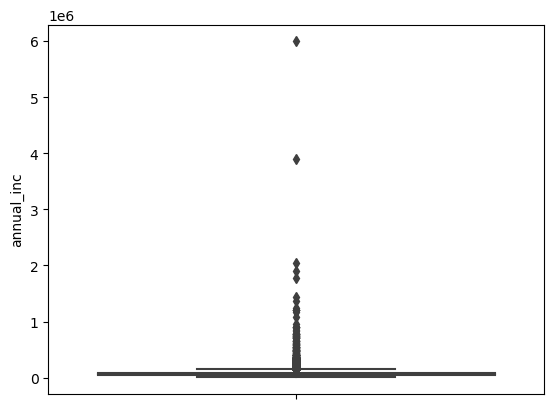

In [331]:
sns.boxplot(y = "annual_inc", data = loan_df)

We have outliers in annual_inc. Let's fix these outliers by replacing them with nearest threshold values

In [332]:
def fix_outliers(df, column_name):
    lower_threshold, upper_threshold = outlier_thresholds(df, column_name)
    # values less than lower_threshold is replaced by lower_threshold
    df.loc[(df[column_name] < lower_threshold), column_name] = lower_threshold
    # values more than upper_threshold is replaced by upper_threshold
    df.loc[(df[column_name] > upper_threshold), column_name] = upper_threshold

<Axes: ylabel='annual_inc'>

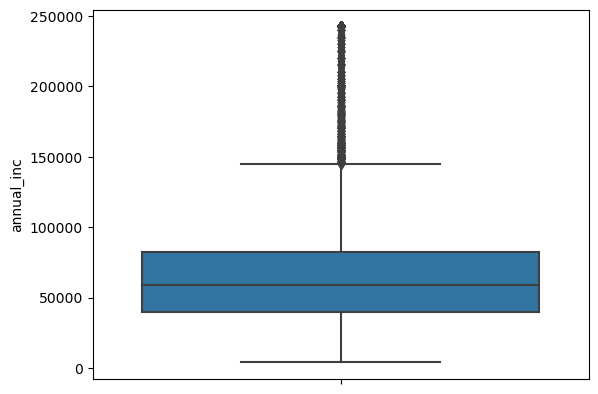

In [333]:
# Fix outliers for annual_inc
fix_outliers(loan_df, "annual_inc")
sns.boxplot(y = "annual_inc", data = loan_df)

### Imputing missing values

In [334]:
loan_df.isnull().sum().sort_values(ascending=False)

emp_length              1033
pub_rec_bankruptcies     697
annual_inc                 0
dti                        0
addr_state                 0
purpose                    0
loan_status                0
issue_d                    0
verification_status        0
loan_amnt                  0
funded_amnt                0
sub_grade                  0
grade                      0
installment                0
int_rate                   0
term                       0
funded_amnt_inv            0
home_ownership             0
dtype: int64

Columns emp_length and pub_rec_bankruptcies have missing values

In [335]:
# Analysing emp_length which is a categorical variable
print("Data type:", loan_df.emp_length.dtypes, "\n")
print(loan_df["emp_length"].value_counts(), "\n")
print(loan_df.emp_length.describe())

Data type: object 

10+ years    8488
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
Name: emp_length, dtype: int64 

count         37544
unique           11
top       10+ years
freq           8488
Name: emp_length, dtype: object


We can observe that "10+ years" is the most frequent value for emp_length, so missing values can be replaced with "10+ years" which is the mode.

In [336]:
loan_df.emp_length.fillna(loan_df.emp_length.mode()[0], inplace = True)

In [337]:
# Analysing pub_rec_bankruptcies which is again a categorical variable
print("Data type:", loan_df.pub_rec_bankruptcies.dtypes, "\n")
print(loan_df["pub_rec_bankruptcies"].value_counts(), "\n")
print(loan_df.pub_rec_bankruptcies.describe())

Data type: float64 

0.0    36238
1.0     1637
2.0        5
Name: pub_rec_bankruptcies, dtype: int64 

count    37880.000000
mean         0.043479
std          0.204583
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: pub_rec_bankruptcies, dtype: float64


In [338]:
# Replace missing values with mode
loan_df.pub_rec_bankruptcies.fillna(loan_df.pub_rec_bankruptcies.mode()[0], inplace = True)
# Caste datatype to int as it is essentially count of public records which is supposed to be an integer
loan_df["pub_rec_bankruptcies"] = loan_df["pub_rec_bankruptcies"].apply(lambda x: int(x))

In [341]:
# Verify there is no null/missing value left in dataframe
loan_df.isnull().sum().sum()

0